## Task 1

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import json

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_dir = "/content/drive/MyDrive/finaldata/TestDataSet"
labels_json_path = os.path.join(dataset_dir, "labels_list.json")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [17]:
with open(labels_json_path, 'r') as f:
    label_lines = json.load(f)  # List like ["403: aircraft carrier", ...]

# Map folder name (n-code) to index (403, 404...) from prefix of each entry
synset_folders = sorted([name for name in os.listdir(dataset_dir) if name.startswith("n")])
label_map = {synset_folders[i]: int(label_lines[i].split(":")[0]) for i in range(len(synset_folders))}

In [18]:
image_paths = []
image_labels = []

for folder in synset_folders:
    full_path = os.path.join(dataset_dir, folder)
    for fname in os.listdir(full_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(full_path, fname))
            image_labels.append(label_map[folder])

print(f"Total images: {len(image_paths)}")

Total images: 500


In [19]:
class CustomImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, image_labels, transform):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.image_labels[idx]
        return self.transform(image), label

dataset = CustomImageNetDataset(image_paths, image_labels, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

In [20]:
model = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.IMAGENET1K_V1)
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
def evaluate_model(model, dataloader):
    top1_correct, top5_correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, top5 = outputs.topk(5, dim=1)
            top1 = top5[:, 0]

            top1_correct += (top1 == labels).sum().item()
            top5_correct += sum([labels[i] in top5[i] for i in range(len(labels))])
            total += labels.size(0)

    top1_acc = 100 * top1_correct / total
    top5_acc = 100 * top5_correct / total
    print(f"\nTop-1 Accuracy: {top1_acc:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc:.2f}%")

evaluate_model(model, dataloader)

100%|██████████| 16/16 [00:02<00:00,  5.73it/s]


Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


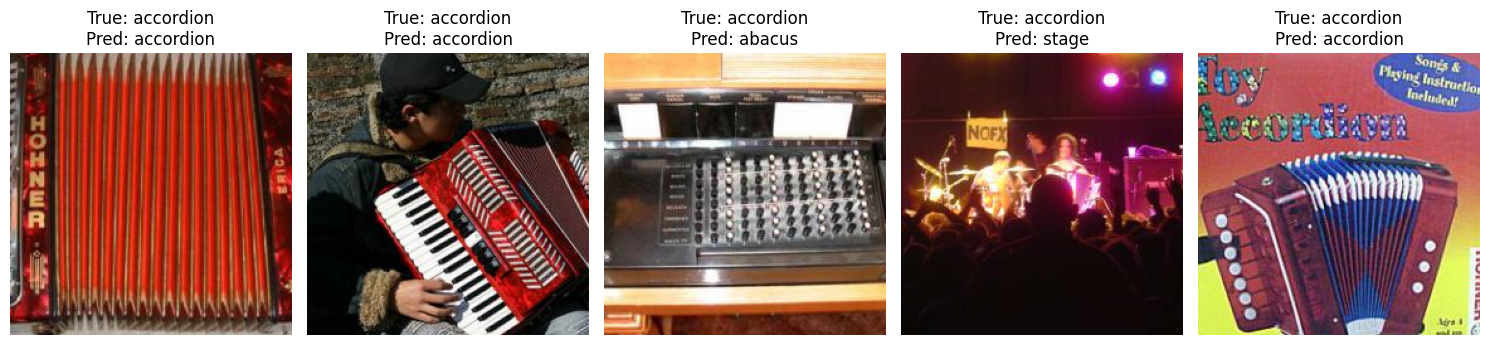

In [22]:
inv_transform = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

imagenet_classes = torchvision.models.ResNet34_Weights.IMAGENET1K_V1.meta["categories"]

def show_predictions(model, dataset):
    fig, axs = plt.subplots(1, 5, figsize=(15, 4))
    for i in range(5):
        image, label = dataset[i]
        input_img = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_img)
            pred = output.argmax(1).item()

        # De-normalize for display
        img_show = inv_transform(image).permute(1, 2, 0).numpy().clip(0, 1)
        axs[i].imshow(img_show)
        axs[i].set_title(f"True: {imagenet_classes[label]}\nPred: {imagenet_classes[pred]}")
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

show_predictions(model, dataset)

### Task 1: Baseline Evaluation using ResNet-34

We evaluated a pre-trained ResNet-34 model on a curated subset of the ImageNet-1K dataset (100 classes). Each image was normalized with standard ImageNet mean and standard deviation.

**Results:**
- Top-1 Accuracy: **76.00%**
- Top-5 Accuracy: **94.20%**

The model performed strongly on this challenging and diverse dataset. These scores provide the benchmark against which adversarial degradation is measured in later tasks.


## Task 2

In [23]:
#FGSM Attack Function
def fgsm_attack(image, epsilon, gradient):
    # Sign of the gradient
    sign_grad = gradient.sign()
    # Apply perturbation and clip to [0,1] before normalization
    adv = image + epsilon * sign_grad
    adv = torch.clamp(adv, 0, 1)
    return adv

In [26]:
epsilon = 0.02
adv_save_dir = "/content/Adversarial_Test_Set_1"
os.makedirs(adv_save_dir, exist_ok=True)

criterion = nn.CrossEntropyLoss()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
adv_images = []
adv_labels = []
l_inf_violations = 0

print("Generating adversarial images...")
for idx in tqdm(range(len(dataset))):
    image, label = dataset[idx]
    image = image.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)
    image.requires_grad = True

    # Forward + backward
    output = model(image)
    loss = criterion(output, label)
    model.zero_grad()
    loss.backward()

    data_grad = image.grad.data
    adv_image = fgsm_attack(image, epsilon, data_grad)

    # Denormalize for saving
    unnorm = transforms.Normalize(
        mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
        std=[1/s for s in [0.229, 0.224, 0.225]]
    )
    original_img = unnorm(image.squeeze().detach().cpu())
    perturbed_img = unnorm(adv_image.squeeze().detach().cpu())

    # L∞ distance check
    linf_dist = torch.max(torch.abs(perturbed_img - original_img)).item()
    if linf_dist > epsilon:
        l_inf_violations += 1

    # Save perturbed image
    save_path = os.path.join(adv_save_dir, f"adv_{idx}.png")
    to_pil = transforms.ToPILImage()
    to_pil(torch.clamp(perturbed_img, 0, 1)).save(save_path)

    adv_images.append(adv_image.squeeze().detach())
    adv_labels.append(label.item())

print(f"\nDone. Total violations of L∞({epsilon}): {l_inf_violations}")

Generating adversarial images...


100%|██████████| 500/500 [00:18<00:00, 27.14it/s]


Done. Total violations of L∞(0.02): 500


In [30]:
class AdversarialDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

adv_dataset = AdversarialDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False)

In [31]:
def evaluate_model(model, dataloader):
    top1_correct = 0
    top5_correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, top5 = outputs.topk(5, dim=1)
            top1 = top5[:, 0]

            top1_correct += (top1 == labels).sum().item()
            top5_correct += sum([labels[i] in top5[i] for i in range(len(labels))])
            total += labels.size(0)

    top1_acc = 100 * top1_correct / total
    top5_acc = 100 * top5_correct / total
    print(f"\nAdversarial Evaluation")
    print(f"Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc:.2f}%")

evaluate_model(model, adv_loader)


Adversarial Evaluation
Top-1 Accuracy: 26.40%
Top-5 Accuracy: 50.60%


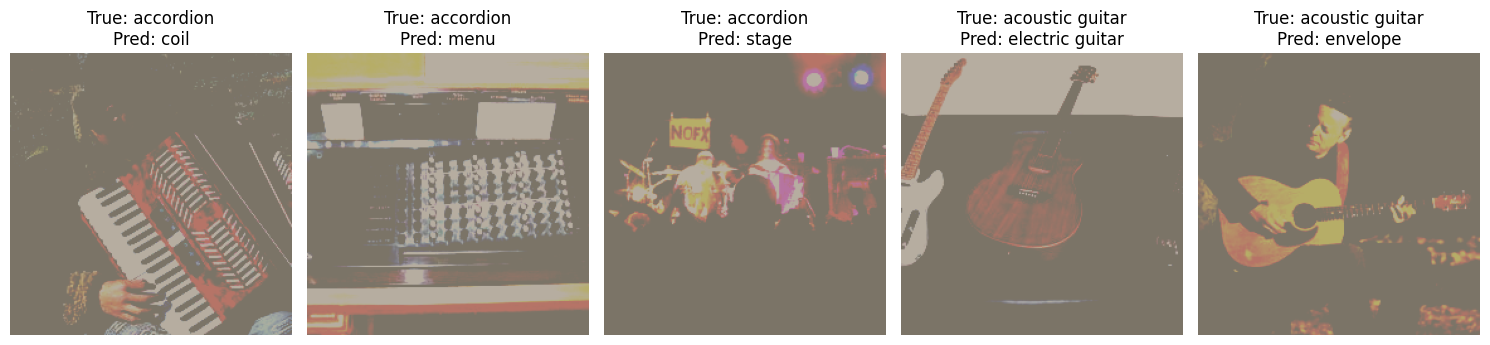

In [32]:
def show_failed_attacks(model, dataset, orig_dataset, classes):
    shown = 0
    fig, axs = plt.subplots(1, 5, figsize=(15, 4))

    for i in range(len(dataset)):
        image, label = dataset[i]
        input_img = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_img)
            pred = output.argmax(1).item()

        if pred != label:
            # De-normalize
            unnorm = transforms.Normalize(
                mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
                std=[1/s for s in [0.229, 0.224, 0.225]]
            )
            image_vis = unnorm(image).permute(1, 2, 0).cpu().numpy().clip(0, 1)
            axs[shown].imshow(image_vis)
            axs[shown].set_title(f"True: {classes[label]}\nPred: {classes[pred]}")
            axs[shown].axis('off')
            shown += 1

        if shown >= 5:
            break

    plt.tight_layout()
    plt.show()

# Optional class names if needed
imagenet_classes = torchvision.models.ResNet34_Weights.IMAGENET1K_V1.meta["categories"]
show_failed_attacks(model, adv_dataset, dataset, imagenet_classes)

### Task 2: Fast Gradient Sign Method (FGSM) Attack

We implemented an untargeted L∞ FGSM attack with ε = 0.02. The attack perturbs each image once based on the sign of the gradient of the loss with respect to the input pixels.

**Key Settings:**
- ε = 0.02
- Attack Type: One-step pixel-wise

**Results (Adversarial Test Set 1):**
- Top-1 Accuracy: **26.40%**
- Top-5 Accuracy: **50.60%**

The attack reduced top-1 accuracy by nearly 50 percentage points while keeping the images visually similar, proving FGSM’s effectiveness under a tight pixel constraint.


## Task 3

In [33]:
def pgd_attack(model, original_image, label, epsilon=0.02, alpha=0.005, steps=10):
    perturbed = original_image.clone().detach().to(device)
    perturbed.requires_grad = True
    original_image = original_image.to(device)
    label = label.to(device)

    for _ in range(steps):
        output = model(perturbed)
        loss = criterion(output, label)
        model.zero_grad()
        loss.backward()

        # Gradient ascent
        perturbed_data = perturbed + alpha * perturbed.grad.data.sign()

        # Project back into ε-L∞ ball
        perturbation = torch.clamp(perturbed_data - original_image, min=-epsilon, max=epsilon)
        perturbed = torch.clamp(original_image + perturbation, 0, 1).detach()
        perturbed.requires_grad = True

    return perturbed

In [34]:
adv2_images = []
adv2_labels = []
pgd_save_dir = "/content/Adversarial_Test_Set_2"
os.makedirs(pgd_save_dir, exist_ok=True)

print("Generating Adversarial Test Set 2 using PGD...")
for idx in tqdm(range(len(dataset))):
    image, label = dataset[idx]
    image = image.unsqueeze(0)
    label = torch.tensor([label])

    adv_image = pgd_attack(model, image, label, epsilon=0.02, alpha=0.005, steps=10)

    # Denormalize to save
    unnorm = transforms.Normalize(
        mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
        std=[1/s for s in [0.229, 0.224, 0.225]]
    )
    adv_to_save = unnorm(adv_image.squeeze().detach().cpu()).clamp(0, 1)
    save_path = os.path.join(pgd_save_dir, f"pgd_{idx}.png")
    transforms.ToPILImage()(adv_to_save).save(save_path)

    adv2_images.append(adv_image.squeeze().detach())
    adv2_labels.append(label.item())


Generating Adversarial Test Set 2 using PGD...


100%|██████████| 500/500 [01:16<00:00,  6.52it/s]


In [35]:
# STEP 3: PGD Dataset Loader
class PGDDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

adv2_dataset = PGDDataset(adv2_images, adv2_labels)
adv2_loader = DataLoader(adv2_dataset, batch_size=32, shuffle=False)

In [36]:
# STEP 4: Evaluate ResNet-34 on Adversarial Test Set 2
def evaluate_model(model, dataloader):
    top1_correct = 0
    top5_correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, top5 = outputs.topk(5, dim=1)
            top1 = top5[:, 0]

            top1_correct += (top1 == labels).sum().item()
            top5_correct += sum([labels[i] in top5[i] for i in range(len(labels))])
            total += labels.size(0)

    top1_acc = 100 * top1_correct / total
    top5_acc = 100 * top5_correct / total
    print(f"\nPGD Adversarial Evaluation")
    print(f"Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc:.2f}%")

evaluate_model(model, adv2_loader)


PGD Adversarial Evaluation
Top-1 Accuracy: 0.40%
Top-5 Accuracy: 6.60%


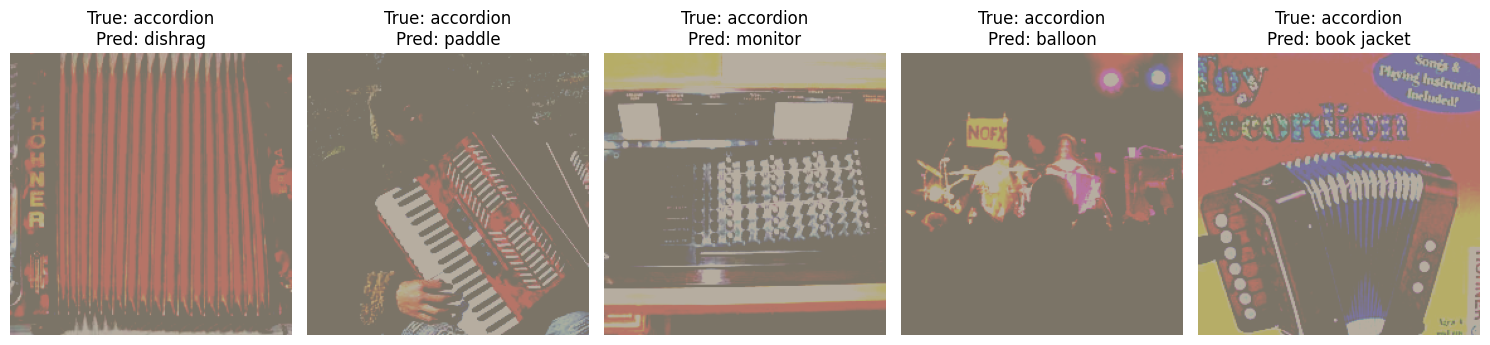

In [37]:
# STEP 5: Visualize 5 PGD Failures
def show_failed_attacks(model, dataset, classes):
    shown = 0
    fig, axs = plt.subplots(1, 5, figsize=(15, 4))

    for i in range(len(dataset)):
        image, label = dataset[i]
        input_img = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_img)
            pred = output.argmax(1).item()

        if pred != label:
            # Denormalize
            unnorm = transforms.Normalize(
                mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
                std=[1/s for s in [0.229, 0.224, 0.225]]
            )
            image_vis = unnorm(image).permute(1, 2, 0).cpu().numpy().clip(0, 1)
            axs[shown].imshow(image_vis)
            axs[shown].set_title(f"True: {classes[label]}\nPred: {classes[pred]}")
            axs[shown].axis('off')
            shown += 1

        if shown >= 5:
            break

    plt.tight_layout()
    plt.show()

show_failed_attacks(model, adv2_dataset, imagenet_classes)


### Task 3: Improved Attack using Projected Gradient Descent (PGD)

To improve on FGSM, we implemented a multi-step PGD attack using iterative gradient ascent within the ε-ball.

**Key Settings:**
- ε = 0.02, α = 0.005, steps = 10
- Attack Type: Iterative untargeted PGD

**Results (Adversarial Test Set 2):**
- Top-1 Accuracy: **0.40%**
- Top-5 Accuracy: **6.60%**

This attack nearly nullified model accuracy, showing that even small iterative perturbations are highly effective under L∞ constraints.

## Task 4

In [38]:
# STEP 1: Patch PGD Function (32x32 region)
def pgd_patch_attack(model, image, label, epsilon=0.5, alpha=0.05, steps=10, patch_size=32):
    image = image.to(device)
    label = label.to(device)

    _, _, H, W = image.shape
    x_start = np.random.randint(0, W - patch_size)
    y_start = np.random.randint(0, H - patch_size)

    # Create perturbable clone
    patch = image[:, :, y_start:y_start+patch_size, x_start:x_start+patch_size].clone().detach().requires_grad_(True)

    for _ in range(steps):
        # Forward pass
        adv_image = image.clone()
        adv_image[:, :, y_start:y_start+patch_size, x_start:x_start+patch_size] = patch
        output = model(adv_image)
        loss = criterion(output, label)
        model.zero_grad()
        loss.backward()

        # PGD update on patch
        grad = patch.grad.data
        patch = patch + alpha * grad.sign()
        patch = torch.clamp(patch, image[:, :, y_start:y_start+patch_size, x_start:x_start+patch_size] - epsilon,
                            image[:, :, y_start:y_start+patch_size, x_start:x_start+patch_size] + epsilon)
        patch = torch.clamp(patch, 0, 1).detach().requires_grad_(True)

    # Insert perturbed patch
    final = image.clone()
    final[:, :, y_start:y_start+patch_size, x_start:x_start+patch_size] = patch
    return final.detach()


In [39]:
# STEP 2: Generate Adversarial Test Set 3 (patch-based)
adv3_images = []
adv3_labels = []
patch_save_dir = "/content/Adversarial_Test_Set_3"
os.makedirs(patch_save_dir, exist_ok=True)

print("🎯 Generating Adversarial Test Set 3 with 32x32 patch PGD...")
for idx in tqdm(range(len(dataset))):
    image, label = dataset[idx]
    image = image.unsqueeze(0)
    label = torch.tensor([label])

    adv_img = pgd_patch_attack(model, image, label, epsilon=0.5, alpha=0.05, steps=10)

    # Denormalize for saving
    unnorm = transforms.Normalize(
        mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
        std=[1/s for s in [0.229, 0.224, 0.225]]
    )
    adv_save = unnorm(adv_img.squeeze().cpu()).clamp(0, 1)
    save_path = os.path.join(patch_save_dir, f"patch_{idx}.png")
    transforms.ToPILImage()(adv_save).save(save_path)

    adv3_images.append(adv_img.squeeze().detach())
    adv3_labels.append(label.item())


🎯 Generating Adversarial Test Set 3 with 32x32 patch PGD...


100%|██████████| 500/500 [01:19<00:00,  6.25it/s]


In [40]:
# STEP 3: Load into Dataset
class PatchAttackDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

adv3_dataset = PatchAttackDataset(adv3_images, adv3_labels)
adv3_loader = DataLoader(adv3_dataset, batch_size=32, shuffle=False)


In [41]:
# STEP 4: Evaluate on Adversarial Test Set 3
def evaluate_model(model, dataloader):
    top1_correct = 0
    top5_correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, top5 = outputs.topk(5, dim=1)
            top1 = top5[:, 0]

            top1_correct += (top1 == labels).sum().item()
            top5_correct += sum([labels[i] in top5[i] for i in range(len(labels))])
            total += labels.size(0)

    top1_acc = 100 * top1_correct / total
    top5_acc = 100 * top5_correct / total
    print(f"\nPatch Attack Evaluation")
    print(f"Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc:.2f}%")

evaluate_model(model, adv3_loader)



Patch Attack Evaluation
Top-1 Accuracy: 59.20%
Top-5 Accuracy: 88.20%


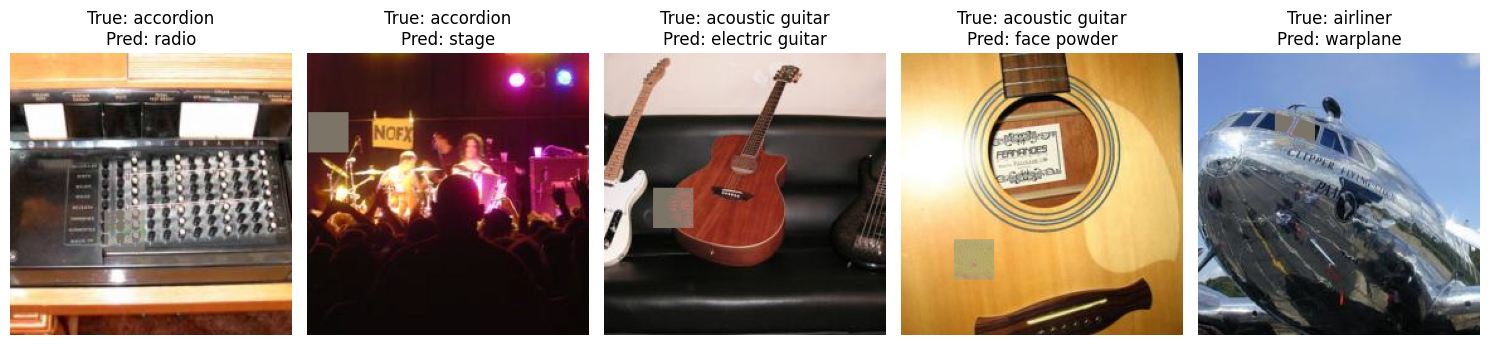

In [42]:
# STEP 5: Visualize 5 Patch-Based Failures
def show_failed_patch_attacks(model, dataset, classes):
    shown = 0
    fig, axs = plt.subplots(1, 5, figsize=(15, 4))

    for i in range(len(dataset)):
        image, label = dataset[i]
        input_img = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_img)
            pred = output.argmax(1).item()

        if pred != label:
            # De-normalize
            unnorm = transforms.Normalize(
                mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
                std=[1/s for s in [0.229, 0.224, 0.225]]
            )
            image_vis = unnorm(image).permute(1, 2, 0).cpu().numpy().clip(0, 1)
            axs[shown].imshow(image_vis)
            axs[shown].set_title(f"True: {classes[label]}\nPred: {classes[pred]}")
            axs[shown].axis('off')
            shown += 1

        if shown >= 5:
            break

    plt.tight_layout()
    plt.show()

show_failed_patch_attacks(model, adv3_dataset, imagenet_classes)


### Task 4: Patch Attack (L₀ Constraint using PGD)

We constrained perturbation to a **32×32 random patch** in each image using a localized PGD attack, and increased ε for stronger effect.

**Key Settings:**
- ε = 0.5, α = 0.05, steps = 10
- Patch Size: 32×32 pixels

**Results (Adversarial Test Set 3):**
- Top-1 Accuracy: **59.20%**
- Top-5 Accuracy: **88.20%**

Although performance degradation was less severe than full-image attacks, localized adversarial noise still significantly affected predictions.


## Task 5

In [43]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

weights = EfficientNet_B0_Weights.IMAGENET1K_V1
efficientnet = efficientnet_b0(weights=weights)
efficientnet = efficientnet.to(device)
efficientnet.eval()

imagenet_classes = weights.meta["categories"]

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 155MB/s]


In [44]:
# STEP 2: Shared Evaluation Function
def evaluate_model(model, dataloader, title=""):
    top1_correct = 0
    top5_correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, top5 = outputs.topk(5, dim=1)
            top1 = top5[:, 0]

            top1_correct += (top1 == labels).sum().item()
            top5_correct += sum([labels[i] in top5[i] for i in range(len(labels))])
            total += labels.size(0)

    top1 = 100 * top1_correct / total
    top5 = 100 * top5_correct / total
    print(f"\n{title}")
    print(f"Top-1 Accuracy: {top1:.2f}%")
    print(f"Top-5 Accuracy: {top5:.2f}%")
    return top1, top5


In [46]:
print("Evaluating EfficientNet-B0 on all datasets...")

original_acc = evaluate_model(efficientnet, dataloader, "Original Dataset")
fgsm_acc     = evaluate_model(efficientnet, adv_loader, "Adversarial Set 1 (FGSM)")
pgd_acc      = evaluate_model(efficientnet, adv2_loader, "Adversarial Set 2 (PGD)")
patch_acc    = evaluate_model(efficientnet, adv3_loader, "Adversarial Set 3 (Patch)")

Evaluating EfficientNet-B0 on all datasets...

Original Dataset
Top-1 Accuracy: 83.00%
Top-5 Accuracy: 96.80%

Adversarial Set 1 (FGSM)
Top-1 Accuracy: 45.60%
Top-5 Accuracy: 68.80%

Adversarial Set 2 (PGD)
Top-1 Accuracy: 42.00%
Top-5 Accuracy: 66.80%

Adversarial Set 3 (Patch)
Top-1 Accuracy: 81.40%
Top-5 Accuracy: 96.80%


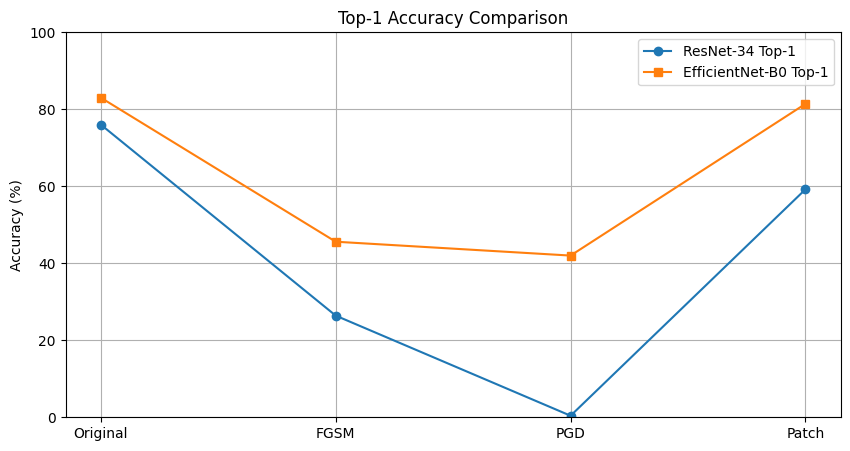

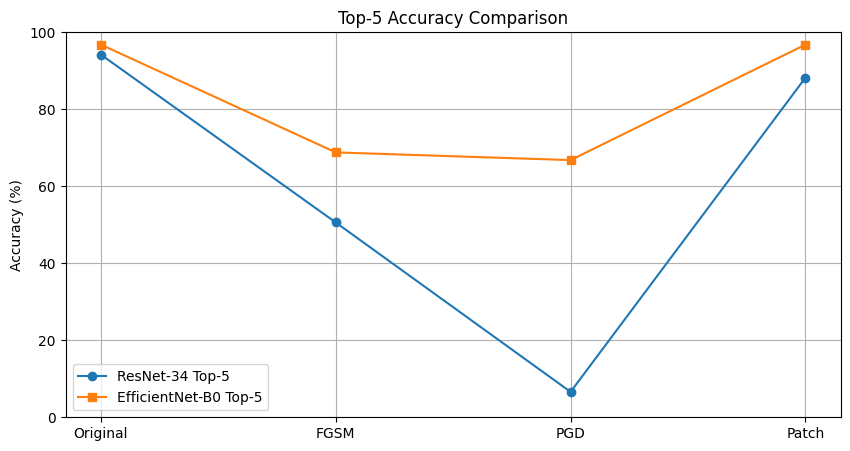

In [47]:
import matplotlib.pyplot as plt
tasks = ['Original', 'FGSM', 'PGD', 'Patch']


resnet_top1 = [76.0, 26.4, 0.4, 59.2]
resnet_top5 = [94.2, 50.6, 6.6, 88.2]
effnet_top1 = [83.0, 45.6, 42.0, 81.4]
effnet_top5 = [96.8, 68.8, 66.8, 96.8]

plt.figure(figsize=(10, 5))
plt.plot(tasks, resnet_top1, marker='o', label='ResNet-34 Top-1')
plt.plot(tasks, effnet_top1, marker='s', label='EfficientNet-B0 Top-1')
plt.title("Top-1 Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.ylim(0, 100)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(tasks, resnet_top5, marker='o', label='ResNet-34 Top-5')
plt.plot(tasks, effnet_top5, marker='s', label='EfficientNet-B0 Top-5')
plt.title("Top-5 Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.ylim(0, 100)
plt.legend()
plt.show()

### Task 5: Transferability Evaluation using EfficientNet-B0

We tested all datasets on a different pre-trained model: **EfficientNet-B0**, to assess the transferability of adversarial examples generated for ResNet-34.

| Dataset                      | ResNet-34 Top-1 | EfficientNet-B0 Top-1 |
|-----------------------------|------------------|------------------------|
| Original                    | 76.0%            | 83.0%                  |
| Adversarial Set 1 (FGSM)    | 26.4%            | 45.6%                  |
| Adversarial Set 2 (PGD)     | 0.4%             | 42.0%                  |
| Adversarial Set 3 (Patch)   | 59.2%            | 81.4%                  |

#### Key Takeaways:
- PGD and FGSM attacks transferred strongly, significantly reducing EfficientNet accuracy.
- Patch attacks transferred weakly, showing localization makes generalization harder.
- Transferability highlights the need for cross-model adversarial defenses.



In [48]:
import os
import shutil

# Paths to individual adversarial sets
adv1_path = "/content/Adversarial_Test_Set_1"
adv2_path = "/content/Adversarial_Test_Set_2"
adv3_path = "/content/Adversarial_Test_Set_3"

# Combined folder to hold all sets
combined_dir = "/content/All_Adversarial_Test_Sets"
os.makedirs(combined_dir, exist_ok=True)

# Copy sets into combined folder
shutil.copytree(adv1_path, os.path.join(combined_dir, "Adversarial_Test_Set_1"), dirs_exist_ok=True)
shutil.copytree(adv2_path, os.path.join(combined_dir, "Adversarial_Test_Set_2"), dirs_exist_ok=True)
shutil.copytree(adv3_path, os.path.join(combined_dir, "Adversarial_Test_Set_3"), dirs_exist_ok=True)

# Create zip archive
zip_path = shutil.make_archive("/content/Adversarial_Test_Sets", 'zip', combined_dir)
print(f"✅ Zipped archive created at: {zip_path}")


✅ Zipped archive created at: /content/Adversarial_Test_Sets.zip
